In [1]:
# -*- coding: utf-8 -*-

# transmission around a 90-degree waveguide bend in 2d
from __future__ import division

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10 # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

pad = 4  # padding distance between waveguide and cell edge
w = 1    # width of waveguide

wvg_xcen =  0.5*(sx-w-2*pad)  # x center of vert. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of horiz. wvg

geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=mp.Medium(epsilon=12))]

fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0),size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen,df,nfreq,refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0),size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen,df,nfreq,tran_fr)

pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf),center=mp.Vector3(-0.5*pad,wvg_ycen),material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf),center=mp.Vector3(wvg_xcen,0.5*pad),material=mp.Medium(epsilon=12))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0),size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen,df,nfreq,tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl,straight_refl_data)

pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

-----------
Initializing structure...
field decay(t = 50.050000000000004): 4.825189380557793e-09 / 4.825189380557793e-09 = 1.0
field decay(t = 100.05000000000001): 0.028801809879425856 / 0.028801809879425856 = 1.0
field decay(t = 150.1): 0.026893465093385728 / 0.028801809879425856 = 0.9337421921042772
field decay(t = 200.15): 2.315839733669588e-13 / 0.028801809879425856 = 8.040604890333206e-12
run 0 finished at t = 200.15 (4003 timesteps)
-----------
Initializing structure...
field decay(t = 50.050000000000004): 1.6976522694449004e-10 / 1.6976522694449004e-10 = 1.0
field decay(t = 100.05000000000001): 4.691071063910547e-07 / 4.691071063910547e-07 = 1.0
field decay(t = 150.1): 2.992872733686027e-07 / 4.691071063910547e-07 = 0.6379934758846145
field decay(t = 200.15): 0.003927813565272278 / 0.003927813565272278 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939073963 / 0.003927813565272278 = 0.03821230740627967
field decay(t = 300.2): 8.806226395700877e-11 / 0.003927813565272278

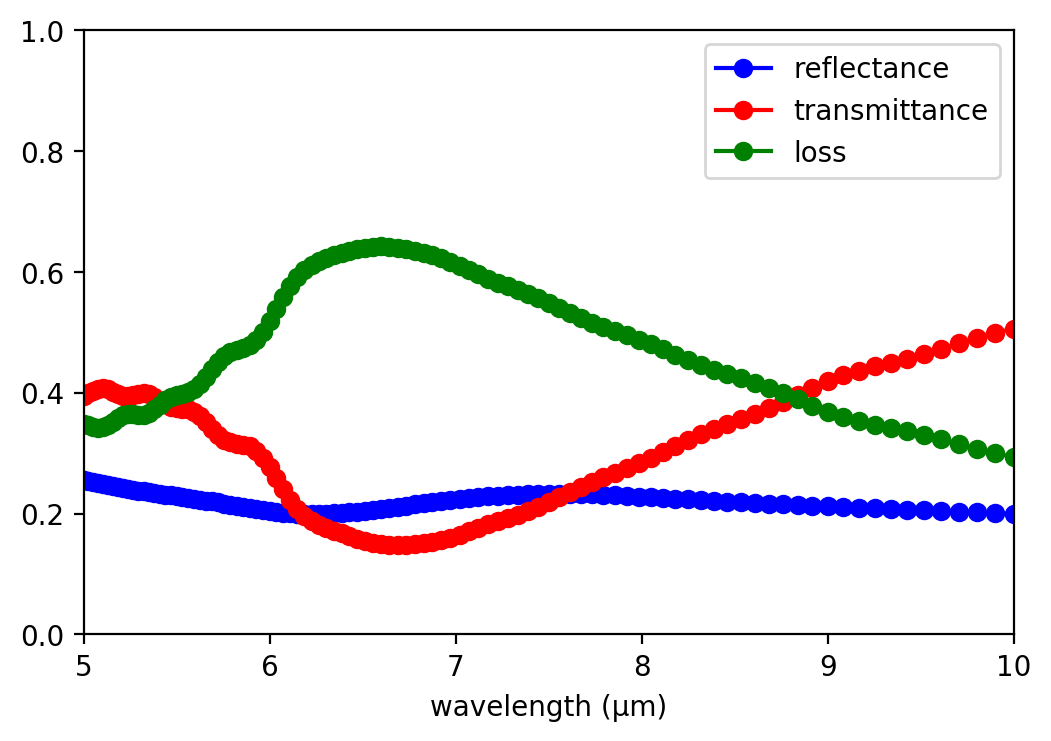

In [2]:
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])

plt.figure(dpi=200)
plt.plot(wl,Rs,'bo-',label='reflectance')
plt.plot(wl,Ts,'ro-',label='transmittance')
plt.plot(wl,1-Rs-Ts,'go-',label='loss')
plt.axis([5.0, 10.0, 0, 1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")